### Restaurant and Bar Employment Growth as Share of Total

In [22]:
import requests
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import config

%matplotlib inline

In [3]:
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
key = '?registrationkey={}'.format(config.bls_key)
headers = {'Content-type': 'application/json'}
series_dict = {
    'TOT_NFP': 'CES0000000001',
    'FSD_NFP': 'CES7072200001',
    'AFS_NFP': 'CES7072000001',
    'MFN_NFP': 'CES3000000001',
    'FSD_AHE': 'CES7072200008',
    'AFS_AHE': 'CES7072000008',
    'TOT_AHE': 'CES0500000008',
    'AFS_QU': 'JTS72000000QUR',
    'TOT_QU': 'JTS00000000QUR'
}
inv_map = {v: k for k, v in series_dict.iteritems()}
series_list = series_dict.values()  # Take just the series codes as a list

date_list = [("1990", "1998"), ("1999", "2008"), ("2009", "2017")]
df = pd.DataFrame()

In [4]:
for start, end in date_list:
    data = json.dumps({"seriesid":series_list, "startyear":start, "endyear":end})
    json_data = requests.post('{}{}'.format(url, key), headers=headers, data=data).json()
    # Store the relevant information in a dictionay and combine into a pandas dataframe
    d = {}
    for series in json_data['Results']['series']:
        seriesId = series['seriesID']
        d[seriesId] = pd.DataFrame(series['data'])
        if len(series['data']) > 0:
            # Convert BLS API dates to readable format (YYYY-MM-DD)
            d[seriesId]['date'] = pd.to_datetime(d[seriesId]['period'] + ' ' + d[seriesId]['year'])
            # Keep only date and series values
            d[seriesId] = d[seriesId].sort_values(by='date')[['date', 'value']].set_index('date')
            # Rename and round
            d[seriesId] = d[seriesId]['value'].rename(inv_map[seriesId]).astype(float)
        else:
            d[seriesId]['date'] = pd.Series()
            d[seriesId]['value'] = pd.Series()
            d[seriesId] = d[seriesId]['value'].rename(inv_map[seriesId])
    df = df.append(pd.concat([d[series_list[x]] for x in range(len(d))], axis=1))

In [5]:
df['OTH_NFP'] = df['TOT_NFP'] - df['FSD_NFP']
for series in ['AFS_NFP', 'FSD_NFP', 'TOT_NFP', 'OTH_NFP', 'MFN_NFP']:
    df[series+'_12ch'] = df[series].diff(12)
    df[series+'_ch'] = df[series].diff()
    df[series+'_12_pct_ch'] = df[series].pct_change(12).multiply(100)
    # Indexed to end of Great Recession
    df[series+'_index'] = df[series] / df.loc['2009-06-01'][series] * 100
    df[series+'_index1'] = df[series] / df.loc['1990-01-01'][series] * 100

In [5]:
df.to_csv('Restaurant_Jobs.csv')

In [7]:
# Select relevant columns to plot and rename them
slist = ['FSD_NFP_index1', 'MFN_NFP_index1', 'TOT_NFP_index1']

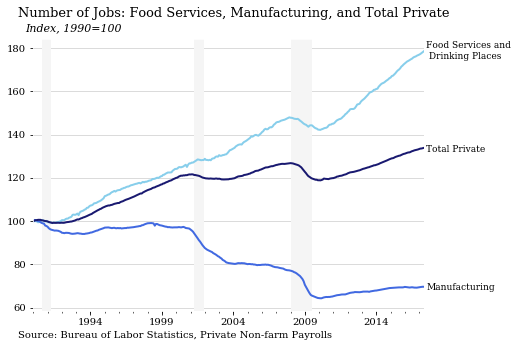

In [158]:
matplotlib.rc('axes',edgecolor='white')
plt.rc('axes', axisbelow=True)
plt.rcParams['font.family'] = 'serif'

df[slist].plot(figsize=(7, 5), legend=None, lw=2, color=['skyblue', 'royalblue', 'midnightblue'])

plt.grid(axis='y', color='lightgray')

# Shaded bars indicating recessions
for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
    plt.axvspan(v['peak'], v['trough'], fill=True, linewidth=0, color='whitesmoke')

plt.xlabel('')
plt.text(570, 175, 'Food Services and \n Drinking Places', size=9)
plt.text(570, 132, 'Total Private', size=9)
plt.text(570, 68, 'Manufacturing', size=9)
plt.annotate('Number of Jobs: Food Services, Manufacturing, and Total Private', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('Index, 1990=100', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, Private Non-farm Payrolls', xy=(-0.04, -0.1), xycoords='axes fraction')

In [49]:
# Restaurant Share of Total
df['Rest_Share'] = df['Food Services and Drinking Places'] / df['Total']

# Take Annual Average
df2 = df.groupby(pd.PeriodIndex(df.index, freq='A'), axis=0).mean().diff().dropna()

# For Bar Chart
df2['All Other'] = df2['Total'] - df2['Food Services and Drinking Places']

# Restaurant Share of Change
df['Rest_Share_Ch'] = df['Food Services and Drinking Places'].diff() / df['Total'].diff()

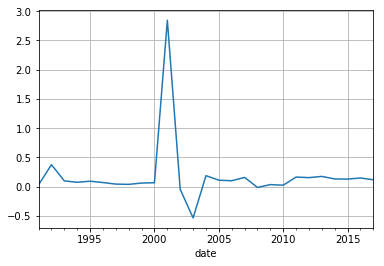

In [47]:
df2['Rest_Share'].plot(grid=True)

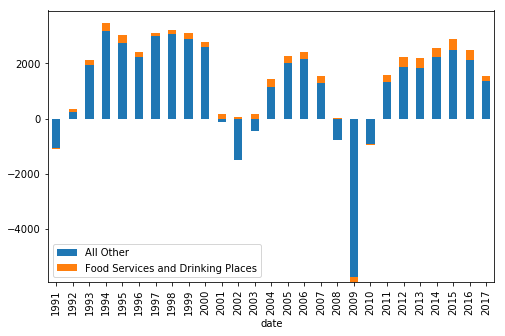

In [37]:
df2[['All Other', 'Food Services and Drinking Places']].plot(kind='bar', stacked=True, figsize=(8,5))